In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications import imagenet_utils

from skimage.io import imread
import matplotlib.pyplot as plt

import os,sys
from lime import lime_image

2022-12-05 17:04:30.743919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 17:04:45.987996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/falconskull/anaconda3/envs/xai/lib/
2022-12-05 17:04:45.988400: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/falconskull/anaconda3/envs/xai/lib/
2022-12-05 17:04:45.988438: W tensorflow/com

In [3]:
def impact_score(el, label, predict, instance, k):
    imps = 0
    fis = el[label]
    keys = instance.keys()
    if label == 0:
        sbsa = sorted(fis, key=lambda tup: tup[1])
        topdrop = []
        for fis_idx in range(k):
            cur = sbsa[fis_idx]
            if cur[1] < 0:
                topdrop.append(cur)
        or_res = predict(instance)
        for td in topdrop:
            if instance[td[0]] == 0:
                instance.at[keys[td[0]]] = float('nan')
            else:
                instance.at[keys[td[0]]] = 0
        res = predict(instance)
        if np.argmax(res) != label or res[label] < 0.5*or_res[label]:
            imps = 1
    else:
        sbsd = sorted(fis, key=lambda tup: tup[1], reverse=True)
        topdrop = []
        for fis_idx in range(k):
            cur = sbsd[len(sbsd) - 1 - fis_idx]
            if cur[1] > 0:
                topdrop.append(cur)
        or_res = predict(instance)
        for td in topdrop:
            if instance[td[0]] == 0:
                instance.at[keys[td[0]]] = float('nan')
            else:
                instance.at[keys[td[0]]] = 0
        res = predict(instance)
        if np.argmax(res) != label or res[label] < 0.5*or_res[label]:
            imps = 1
    return imps
def eval_impact(df, predict_proba, explainer, k):
    errors = 0
    iscore = 0
    for i in range(len(df)):
        sample = df.iloc[i]
        label = np.argmax(predict_proba(sample))
        exp = explainer.explain_instance(sample, predict_proba, top_labels=1)
        el = exp.as_map()
        try:
            iscore += impact_score(el, label, predict_proba, sample, k)
        except:
            errors += 1
            pass
        if i % 100 == 0:
            print('avg impact score at ' + str(i) + ': ' + str(iscore / float(1 + i)))
    return iscore / float(1 + i), errors

In [5]:
# from keras.applications import inception_v3 as inc_net
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2022-12-05 17:05:10.093734: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:05:10.095147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 17:05:10.096306: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
# Instantiates the MobileNet architecture.

model = MobileNetV3Large(
    input_shape= (224,224,3),
    #alpha=1.0,
    minimalistic=False,
    #include_top=True,
    weights="imagenet",
    #input_tensor=None,
    classes=1000,
    #pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
) 

2022-12-04 19:57:01.823828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 19:57:01.824455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 19:57:01.824828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-04 19:57:01.825099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

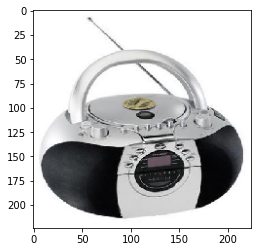

In [7]:

## Load a test image and predict it with pre-trained MobileNetV3Large
img_path = '3.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
plt.imshow(img)


In [9]:
## See the prediction
predictions = model.predict(x)
# results = imagenet_utils.decode_predictions(predictions, top=5)
results = tf.keras.applications.mobilenet.decode_predictions(predictions)
results

2022-12-04 19:57:24.389365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:433] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-12-04 19:57:24.389414: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at conv_ops.cc:1152 : UNIMPLEMENTED: DNN library is not found.


UnimplementedError: Graph execution error:

Detected at node 'MobilenetV3large/Conv/Conv2D' defined at (most recent call last):
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/asyncio/base_events.py", line 600, in run_forever
      self._run_once()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/asyncio/base_events.py", line 1896, in _run_once
      handle._run()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_24948/3368268386.py", line 2, in <cell line: 2>
      predictions = model.predict(x)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 1983, in predict_step
      return self(x, training=False)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 283, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 255, in convolution_op
      return tf.nn.convolution(
Node: 'MobilenetV3large/Conv/Conv2D'
DNN library is not found.
	 [[{{node MobilenetV3large/Conv/Conv2D}}]] [Op:__inference_predict_function_5174]

In [19]:
# initialize LIME explainer
explainer = lime_image.LimeImageExplainer()


In [20]:
## time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
img_explained = image.img_to_array(img)

In [21]:
explanation = explainer.explain_instance(
    img_explained.astype('double'), 
    model.predict, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000)


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  1%|▍                                        | 10/1000 [00:01<02:13,  7.40it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▊                                        | 20/1000 [00:01<01:03, 15.42it/s]

1/1 [==============================] - 0s 26ms/step


  3%|█▏                                       | 30/1000 [00:01<00:40, 23.95it/s]

1/1 [==============================] - 0s 29ms/step


  4%|█▋                                       | 40/1000 [00:01<00:29, 32.13it/s]

1/1 [==============================] - 0s 28ms/step


  5%|██                                       | 50/1000 [00:01<00:23, 39.63it/s]

1/1 [==============================] - 0s 29ms/step


  6%|██▍                                      | 60/1000 [00:02<00:20, 46.19it/s]

1/1 [==============================] - 0s 32ms/step


  7%|██▊                                      | 70/1000 [00:02<00:18, 51.08it/s]

1/1 [==============================] - 0s 25ms/step


  8%|███▎                                     | 80/1000 [00:02<00:16, 55.66it/s]

1/1 [==============================] - 0s 26ms/step


  9%|███▋                                     | 90/1000 [00:02<00:15, 60.11it/s]

1/1 [==============================] - 0s 26ms/step


 10%|████                                    | 100/1000 [00:02<00:14, 62.38it/s]

1/1 [==============================] - 0s 28ms/step


 11%|████▍                                   | 110/1000 [00:02<00:13, 63.91it/s]

1/1 [==============================] - 0s 25ms/step


 12%|████▊                                   | 120/1000 [00:02<00:13, 65.57it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█████▏                                  | 130/1000 [00:03<00:13, 66.54it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█████▌                                  | 140/1000 [00:03<00:12, 67.69it/s]

1/1 [==============================] - 0s 25ms/step


 15%|██████                                  | 150/1000 [00:03<00:12, 68.17it/s]

1/1 [==============================] - 0s 29ms/step


 16%|██████▍                                 | 160/1000 [00:03<00:12, 66.33it/s]

1/1 [==============================] - 0s 28ms/step


 17%|██████▊                                 | 170/1000 [00:03<00:12, 66.93it/s]

1/1 [==============================] - 0s 26ms/step


 18%|███████▏                                | 180/1000 [00:03<00:12, 67.48it/s]

1/1 [==============================] - 0s 26ms/step


 19%|███████▌                                | 190/1000 [00:03<00:11, 68.37it/s]

1/1 [==============================] - 0s 32ms/step


 20%|████████                                | 200/1000 [00:04<00:11, 68.37it/s]

1/1 [==============================] - 0s 29ms/step


 21%|████████▍                               | 210/1000 [00:04<00:11, 68.66it/s]

1/1 [==============================] - 0s 26ms/step


 22%|████████▊                               | 220/1000 [00:04<00:11, 68.53it/s]

1/1 [==============================] - 0s 26ms/step


 23%|█████████▏                              | 230/1000 [00:04<00:11, 68.67it/s]

1/1 [==============================] - 0s 29ms/step


 24%|█████████▌                              | 240/1000 [00:04<00:11, 68.10it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██████████                              | 250/1000 [00:04<00:10, 68.33it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██████████▍                             | 260/1000 [00:05<00:10, 69.25it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██████████▊                             | 270/1000 [00:05<00:10, 69.35it/s]

1/1 [==============================] - 0s 27ms/step


 28%|███████████▏                            | 280/1000 [00:05<00:10, 70.61it/s]

1/1 [==============================] - 0s 26ms/step


 29%|███████████▌                            | 290/1000 [00:05<00:09, 71.17it/s]

1/1 [==============================] - 0s 27ms/step


 30%|████████████                            | 300/1000 [00:05<00:09, 71.40it/s]

1/1 [==============================] - 0s 27ms/step


 31%|████████████▍                           | 310/1000 [00:05<00:09, 71.71it/s]

1/1 [==============================] - 0s 24ms/step


 32%|████████████▊                           | 320/1000 [00:05<00:09, 71.53it/s]

1/1 [==============================] - 0s 27ms/step


 33%|█████████████▏                          | 330/1000 [00:05<00:09, 70.77it/s]

1/1 [==============================] - 0s 27ms/step


 34%|█████████████▌                          | 340/1000 [00:06<00:09, 71.09it/s]

1/1 [==============================] - 0s 28ms/step


 35%|██████████████                          | 350/1000 [00:06<00:09, 70.23it/s]

1/1 [==============================] - 0s 25ms/step


 36%|██████████████▍                         | 360/1000 [00:06<00:09, 70.97it/s]

1/1 [==============================] - 0s 25ms/step


 37%|██████████████▊                         | 370/1000 [00:06<00:08, 71.17it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███████████████▏                        | 380/1000 [00:06<00:08, 71.55it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███████████████▌                        | 390/1000 [00:06<00:08, 71.18it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████████████████                        | 400/1000 [00:06<00:08, 70.83it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████████████████▍                       | 410/1000 [00:07<00:08, 71.21it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████████████████▊                       | 420/1000 [00:07<00:08, 70.55it/s]

1/1 [==============================] - 0s 25ms/step


 43%|█████████████████▏                      | 430/1000 [00:07<00:08, 70.87it/s]

1/1 [==============================] - 0s 25ms/step


 44%|█████████████████▌                      | 440/1000 [00:07<00:07, 71.12it/s]

1/1 [==============================] - 0s 25ms/step


 45%|██████████████████                      | 450/1000 [00:07<00:07, 71.02it/s]

1/1 [==============================] - 0s 25ms/step


 46%|██████████████████▍                     | 460/1000 [00:07<00:07, 70.62it/s]

1/1 [==============================] - 0s 25ms/step


 47%|██████████████████▊                     | 470/1000 [00:07<00:07, 70.96it/s]

1/1 [==============================] - 0s 27ms/step


 48%|███████████████████▏                    | 480/1000 [00:08<00:07, 70.54it/s]

1/1 [==============================] - 0s 25ms/step


 49%|███████████████████▌                    | 490/1000 [00:08<00:07, 70.59it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████████████████████                    | 500/1000 [00:08<00:07, 70.66it/s]

1/1 [==============================] - 0s 27ms/step


 51%|████████████████████▍                   | 510/1000 [00:08<00:07, 69.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|████████████████████▊                   | 520/1000 [00:08<00:06, 70.15it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████████████████████▏                  | 530/1000 [00:08<00:06, 70.31it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████████████████████▌                  | 540/1000 [00:08<00:06, 70.56it/s]

1/1 [==============================] - 0s 24ms/step


 55%|██████████████████████                  | 550/1000 [00:09<00:06, 70.86it/s]

1/1 [==============================] - 0s 25ms/step


 56%|██████████████████████▍                 | 560/1000 [00:09<00:06, 70.92it/s]

1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████▊                 | 570/1000 [00:09<00:06, 70.74it/s]

1/1 [==============================] - 0s 25ms/step


 58%|███████████████████████▏                | 580/1000 [00:09<00:05, 70.87it/s]

1/1 [==============================] - 0s 29ms/step


 59%|███████████████████████▌                | 590/1000 [00:09<00:05, 70.20it/s]

1/1 [==============================] - 0s 26ms/step


 60%|████████████████████████                | 600/1000 [00:09<00:05, 70.55it/s]

1/1 [==============================] - 0s 25ms/step


 61%|████████████████████████▍               | 610/1000 [00:09<00:05, 71.15it/s]

1/1 [==============================] - 0s 25ms/step


 62%|████████████████████████▊               | 620/1000 [00:10<00:05, 71.43it/s]

1/1 [==============================] - 0s 25ms/step


 63%|█████████████████████████▏              | 630/1000 [00:10<00:05, 71.39it/s]

1/1 [==============================] - 0s 25ms/step


 64%|█████████████████████████▌              | 640/1000 [00:10<00:05, 71.37it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████████████████████████              | 650/1000 [00:10<00:04, 71.05it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████████████████████████▍             | 660/1000 [00:10<00:04, 70.88it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████████████████████████▊             | 670/1000 [00:10<00:04, 70.81it/s]

1/1 [==============================] - 0s 27ms/step


 68%|███████████████████████████▏            | 680/1000 [00:10<00:04, 70.38it/s]

1/1 [==============================] - 0s 26ms/step


 69%|███████████████████████████▌            | 690/1000 [00:11<00:04, 70.84it/s]

1/1 [==============================] - 0s 27ms/step


 70%|████████████████████████████            | 700/1000 [00:11<00:04, 70.82it/s]

1/1 [==============================] - 0s 26ms/step


 71%|████████████████████████████▍           | 710/1000 [00:11<00:04, 70.87it/s]

1/1 [==============================] - 0s 25ms/step


 72%|████████████████████████████▊           | 720/1000 [00:11<00:03, 70.88it/s]

1/1 [==============================] - 0s 27ms/step


 73%|█████████████████████████████▏          | 730/1000 [00:11<00:03, 70.64it/s]

1/1 [==============================] - 0s 24ms/step


 74%|█████████████████████████████▌          | 740/1000 [00:11<00:03, 70.62it/s]

1/1 [==============================] - 0s 24ms/step


 75%|██████████████████████████████          | 750/1000 [00:11<00:03, 70.60it/s]

1/1 [==============================] - 0s 24ms/step


 76%|██████████████████████████████▍         | 760/1000 [00:12<00:03, 70.99it/s]

1/1 [==============================] - 0s 26ms/step


 77%|██████████████████████████████▊         | 770/1000 [00:12<00:03, 69.75it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████████████████████████████▏        | 780/1000 [00:12<00:03, 70.20it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████████████████████████████▌        | 790/1000 [00:12<00:02, 70.70it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████████████████████████████        | 800/1000 [00:12<00:02, 70.85it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████████████████████████████▍       | 810/1000 [00:12<00:02, 70.57it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████████████████████████████▊       | 820/1000 [00:12<00:02, 70.71it/s]

1/1 [==============================] - 0s 25ms/step


 83%|█████████████████████████████████▏      | 830/1000 [00:13<00:02, 70.68it/s]

1/1 [==============================] - 0s 25ms/step


 84%|█████████████████████████████████▌      | 840/1000 [00:13<00:02, 70.76it/s]

1/1 [==============================] - 0s 25ms/step


 85%|██████████████████████████████████      | 850/1000 [00:13<00:02, 70.47it/s]

1/1 [==============================] - 0s 25ms/step


 86%|██████████████████████████████████▍     | 860/1000 [00:13<00:02, 69.78it/s]

1/1 [==============================] - 0s 25ms/step


 87%|██████████████████████████████████▊     | 870/1000 [00:13<00:01, 70.20it/s]

1/1 [==============================] - 0s 25ms/step


 88%|███████████████████████████████████▏    | 880/1000 [00:13<00:01, 70.07it/s]

1/1 [==============================] - 0s 25ms/step


 89%|███████████████████████████████████▌    | 890/1000 [00:13<00:01, 70.23it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████████████████████████████████    | 900/1000 [00:14<00:01, 70.47it/s]

1/1 [==============================] - 0s 25ms/step


 91%|████████████████████████████████████▍   | 910/1000 [00:14<00:01, 70.42it/s]

1/1 [==============================] - 0s 25ms/step


 92%|████████████████████████████████████▊   | 920/1000 [00:14<00:01, 70.48it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████████████████████████████████▏  | 930/1000 [00:14<00:00, 70.57it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████████████████████████████████▌  | 940/1000 [00:14<00:00, 70.58it/s]

1/1 [==============================] - 0s 26ms/step


 95%|██████████████████████████████████████  | 950/1000 [00:14<00:00, 69.38it/s]

1/1 [==============================] - 0s 26ms/step


 96%|██████████████████████████████████████▍ | 960/1000 [00:14<00:00, 69.49it/s]

1/1 [==============================] - 0s 25ms/step


 97%|██████████████████████████████████████▊ | 970/1000 [00:15<00:00, 69.58it/s]

1/1 [==============================] - 0s 25ms/step


 98%|███████████████████████████████████████▏| 980/1000 [00:15<00:00, 69.42it/s]

1/1 [==============================] - 0s 25ms/step


 99%|███████████████████████████████████████▌| 990/1000 [00:15<00:00, 69.86it/s]

1/1 [==============================] - 0s 25ms/step


100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 64.58it/s]


In [58]:
# explanation.as_map()

In [59]:
## Show the explaination

from skimage.segmentation import mark_boundaries


In [60]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

# final = mark_boundaries(temp / 2 + 0.5, mask).astype(np.int32)
# zz = mark_boundaries(temp, mask)
final = mark_boundaries(temp, mask).astype(np.int32)


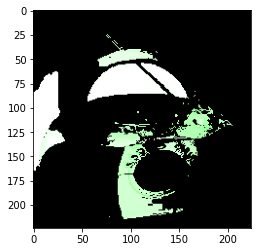

In [61]:
plt.imshow(final)


In [ ]:
# inet_model = inc_net.InceptionV3()



In [ ]:
%matplotlib inline


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)
images = transform_img_fn(['2.jpeg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in imagenet_utils.decode_predictions(preds)[0]:
    print(x)


In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)


In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
temp, mask = explanation.get_image_and_mask(106, positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[3], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
explanation.top_labels

In [ ]:
# https://uwspace.uwaterloo.ca/bitstream/handle/10012/15922/Lin_ZhongQiu.pdf

In [62]:
k=2

In [66]:
explanation.as_list()

AttributeError: 'ImageExplanation' object has no attribute 'as_list'

In [63]:
iscore = impact_score(el, label, model.predict, img_explained, k)

NameError: name 'el' is not defined

First get predictions and explanation like normal
Then create new image: new_img = original_image - mask
Take out the explanation/critical parts of the image
Predict again
If the labels are different:
impact score = difference_confidence_correct_label / size_mask